In [1]:
import torch
from torch import nn,optim
from torch.autograd.variable import Variable
from torchvision import transforms,datasets
from utils import Logger
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
def temper_data(flag="train"):
    if flag == "train":
        return torch.load('5_train2.pt')
    elif flag == 'test':
        return torch.load('5_test2.pt')
    else:
        raise NameError('No such data loader')

train_dataloader = temper_data()
num_batches_train = len(train_dataloader)
test_dataloader = temper_data('test')
num_batches_test = len(test_dataloader)

In [3]:
def images_to_vectors(images):
    return images.view(images.size(0), 133)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 19, 7)

In [4]:
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [5]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 19*7
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024,512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [6]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 19*7
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
#             nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [7]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [8]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 400

In [9]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [10]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [11]:
num_test_samples = 16
test_noise = noise(num_test_samples)

In [12]:
torch.cuda.is_available()

True

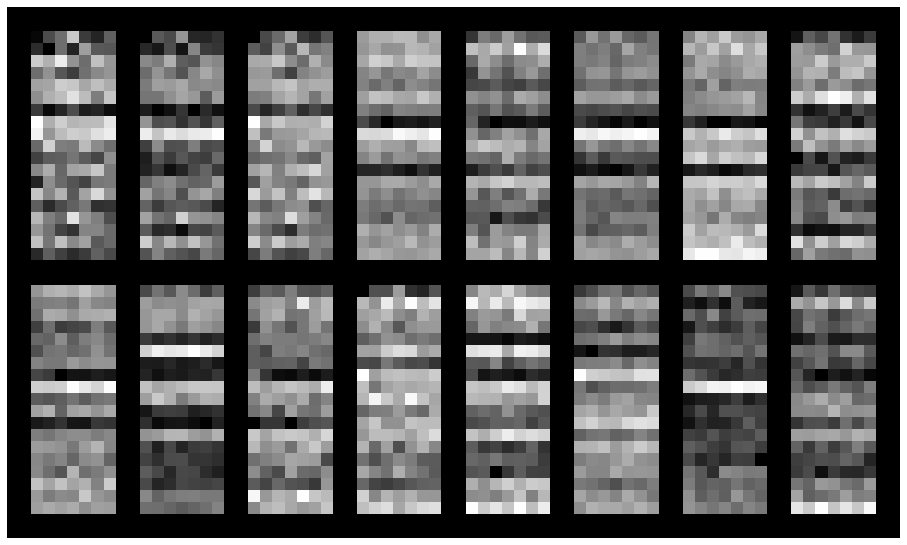

Epoch: [399/400], Batch Num: [50/54]
Discriminator Loss: 1.4982, Generator Loss: 0.8853
D(x): 0.5644, D(G(z)): 0.4992


In [13]:
logger = Logger(model_name='VGAN', data_name='MNIST')

for epoch in range(num_epochs):
    for n_batch, (real_batch) in enumerate(train_dataloader):

        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches_train)

        # Display Progress
        if (n_batch) % 10 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches_train);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches_train,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)

In [14]:
mean_list = []
std_list = []
for item in real_data:
#     print(torch.mean(item),torch.std(item))
    mean_list.append(torch.mean(item).cpu().numpy())
    std_list.append(torch.std(item).cpu().numpy())

In [13]:
with open('4_tensor.pkl','rb') as f:
    tensor_array = pickle.load(f)
tensor_array = np.array(tensor_array)

In [16]:
mean_list = []
std_list = []
for item in tensor_array:
    mean_list.append(np.mean(item))
    std_list.append(np.std(item))

In [17]:
len(tensor_array)

29898

In [18]:
g2 = generator(noise(29898))
mean_g2 = torch.mean(g2,axis=1)
mean_g2 = mean_g2.cpu().detach().numpy()
std_g2 = torch.std(g2,axis=1)
std_g2 = std_g2.cpu().detach().numpy()
print(mean_g2.shape)
print(std_g2.shape)

(29898,)
(29898,)


(array([2.500e+01, 1.860e+02, 8.150e+02, 1.720e+03, 2.528e+03, 2.748e+03,
        2.713e+03, 2.486e+03, 2.080e+03, 1.765e+03, 1.555e+03, 1.286e+03,
        1.157e+03, 9.680e+02, 8.940e+02, 8.040e+02, 6.290e+02, 5.400e+02,
        5.400e+02, 4.720e+02, 3.700e+02, 3.680e+02, 3.000e+02, 2.950e+02,
        2.900e+02, 2.160e+02, 1.760e+02, 1.760e+02, 1.850e+02, 1.680e+02,
        1.240e+02, 1.140e+02, 1.230e+02, 1.220e+02, 9.300e+01, 8.000e+01,
        7.200e+01, 8.300e+01, 5.700e+01, 5.700e+01, 5.700e+01, 3.300e+01,
        3.800e+01, 4.100e+01, 4.600e+01, 2.500e+01, 2.700e+01, 2.000e+01,
        1.400e+01, 2.700e+01, 1.200e+01, 1.300e+01, 2.300e+01, 8.000e+00,
        2.000e+01, 3.000e+00, 9.000e+00, 1.000e+01, 1.100e+01, 8.000e+00,
        1.100e+01, 5.000e+00, 2.000e+00, 7.000e+00, 2.000e+00, 3.000e+00,
        3.000e+00, 4.000e+00, 1.000e+00, 2.000e+00, 4.000e+00, 3.000e+00,
        2.000e+00, 1.000e+00, 6.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 2.000e+0

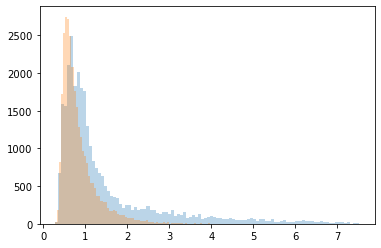

In [19]:
plt.hist(std_list,bins=100,label='origin',alpha=0.3)
plt.hist(std_g2,bins=100,label='generator',alpha=0.3)

(array([2.000e+00, 2.000e+00, 6.000e+00, 9.000e+00, 1.500e+01, 2.600e+01,
        3.800e+01, 7.400e+01, 1.100e+02, 1.580e+02, 2.490e+02, 3.130e+02,
        3.960e+02, 5.280e+02, 6.490e+02, 8.050e+02, 9.130e+02, 1.015e+03,
        1.077e+03, 1.091e+03, 1.116e+03, 1.067e+03, 1.045e+03, 9.520e+02,
        9.280e+02, 9.460e+02, 9.490e+02, 9.320e+02, 9.630e+02, 8.590e+02,
        9.240e+02, 8.690e+02, 8.820e+02, 8.150e+02, 7.890e+02, 7.140e+02,
        6.220e+02, 6.780e+02, 6.000e+02, 5.490e+02, 5.350e+02, 4.640e+02,
        4.000e+02, 3.790e+02, 3.650e+02, 3.590e+02, 2.890e+02, 2.690e+02,
        2.370e+02, 2.220e+02, 2.010e+02, 1.780e+02, 1.480e+02, 1.490e+02,
        1.510e+02, 1.240e+02, 1.100e+02, 8.200e+01, 7.100e+01, 5.900e+01,
        5.500e+01, 5.300e+01, 4.500e+01, 3.200e+01, 2.900e+01, 3.400e+01,
        3.000e+01, 2.000e+01, 2.100e+01, 1.500e+01, 1.300e+01, 1.200e+01,
        1.000e+01, 1.200e+01, 5.000e+00, 1.100e+01, 4.000e+00, 5.000e+00,
        4.000e+00, 5.000e+00, 1.000e+0

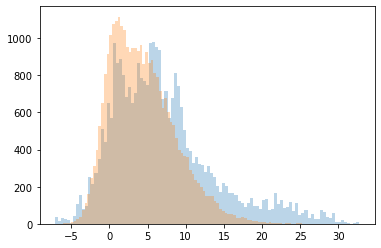

In [20]:
plt.hist(mean_list,bins=100,label='y',alpha=0.3)
plt.hist(mean_g2,bins=100,label='x',alpha=0.3)

In [35]:
while True:
    g1 = generator(noise(1))
    loss = g1.cpu().detach().numpy().reshape(19,7) - tensor_array[1100]
    mre = np.sum(np.abs(loss))
    if mre < 50:
        print(mre)
        break
print(g1)
print(discriminator(g1))

48.390679678857325
tensor([[-1.0417, -0.7761, -1.4222, -1.3845, -1.0008, -1.7157, -1.0439, -0.8490,
         -0.4367, -0.8290, -0.5469, -0.3647, -0.4554, -0.4982, -2.0259, -1.3453,
         -1.4392, -1.4120, -1.0750, -1.3635, -1.4317, -1.8638, -1.4873, -1.7055,
         -2.4729, -1.8024, -1.6066, -1.8717, -2.7726, -3.2745, -3.1388, -3.2609,
         -3.0151, -3.0686, -2.8170, -1.4290, -1.6637, -1.4258, -1.3486, -1.1492,
         -0.8480, -1.3276, -2.7925, -2.5052, -2.8143, -2.7373, -2.5529, -2.1538,
         -2.3976, -3.1808, -2.8202, -2.9020, -2.9586, -2.8566, -3.2030, -3.0423,
          0.6063,  0.4571,  0.4896,  0.6097,  0.6440,  1.0009,  0.7250, -0.4447,
         -0.5320, -0.4898, -0.8067, -0.4286, -0.6005, -0.3203, -2.5132, -2.2436,
         -2.6677, -2.4521, -2.5008, -2.1921, -2.2757, -3.0574, -3.1338, -3.0760,
         -3.5528, -3.5892, -3.4597, -2.5603, -0.1147, -0.6603, -0.3738,  0.2330,
          0.1034, -0.5556, -0.1490, -1.3065, -1.5332, -1.6382, -1.4485, -1.4523,
         

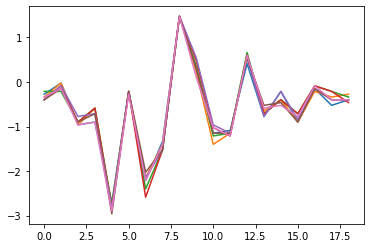

In [42]:
plt.plot(tensor_array[1000].reshape(19,7))

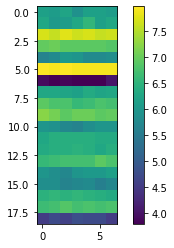

In [51]:
plt.imshow(tensor_array[5646])
plt.colorbar()

In [21]:
# Save Entire Model
torch.save(generator,'generator_1.pkl')
torch.save(discriminator,'discriminator_1.pkl')



In [11]:
# Load Entire Model
generator = torch.load('generator_1.pkl')
discriminator = torch.load('discriminator_1.pkl')


In [22]:
# Save the Parameters
torch.save(generator.state_dict(),'gen_param.pkl')
torch.save(discriminator.state_dict(),'dis_param.pkl')

In [ ]:
# Load the Parameters
model_object.load_state_dict(torch.load('params.pkl'))